# Clase 18

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


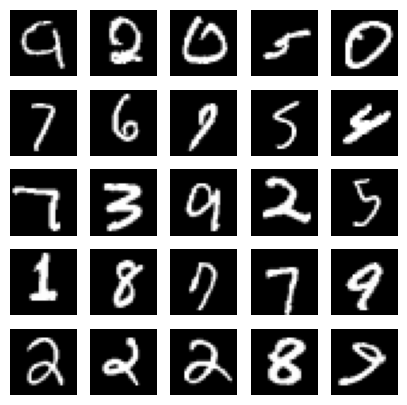

In [4]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]
# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()
#plt.savefig("mnist-samples.png")
plt.close('all')

In [19]:
images[0].shape

(28, 28)

## Preprocesado

In [5]:
# Dimensión de las imágenes (que asumimos cuadradas)
image_size = x_train.shape[1]
input_size = image_size * image_size
# "Flateamos" la matriz y luego normalizamos ambos conjuntos
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

## Implementación

In [8]:
class NeuralNetMLP(object):
    def __init__(self, n_hidden=30,
        l2=0., epochs=100, eta=0.001,
        shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    def _onehot(self, y, n_classes):
        # Vector de ceros con dimensión (#Clases, #Muestras)
        onehot = np.zeros((n_classes, y.shape[0]))
        # Para cada valor de y
        for idx, val in enumerate(y.astype(int)):
            # Asigna el 1 en el indice con igual valor al número de clase
            onehot[val, idx] = 1.
        # Retorna el transpuesto: (#Muestras, #Clases)
        return onehot.T
    def _sigmoid(self, z):
        # Retorna el valor sigmoide para los valores entre -250, 250 de
        # un vector. Valores fuera del intervalo se consideran 0
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    def _forward(self, X):
        # Calcula la salida de la red a partir de un conjunto de datos X
        # Retorna un vector categórico y_pred
        # Capa de entrada
        # ---------------
        # z = Sigmoide(X * W_in + b)
        # [#Muestras, #Caracteristicas] * [#Caracteristicas, #NeuronasOcultas]␣+ [#NeuronasOcultas]
        # z.shape = [#Muestras, #NeuronasOcultas]
        z_h = np.dot(X, self.w_h) + self.b_h
        # Activación sigmoide
        a_h = self._sigmoid(z_h)
        # Capa de salida
        # ---------------
        # pred = z * W_out + b
        # [#Muestras, #NeuronasOcultas] punto [#NeuronasOcultas, #Clases] + [#Clases]
        # pred.shape = [#Muestras, #Clases] <---- OJO: Vector categórico
        z_out = np.dot(a_h, self.w_out) + self.b_out
        # Activación sigmoide
        a_out = self._sigmoid(z_out)
        # Retorna z, Sigmoide(z), pred, Sigmoide(pred)
        return z_h, a_h, z_out, a_out
    def _compute_cost(self, y_enc, output):
        # Calcula función de costo
        # L2(X, w) = lambda * Sum(w^2)
        L2_term = self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.))
        # -1 * sum(y_real * log(y_pred) + (1 - y_real) * log(1 - y_pred))
        term1 = -y_enc * np.log(output)
        term2 = -(1. - y_enc) * np.log(1. - output)
        # Costo total L + L2
        cost = np.sum(term1 - term2) + L2_term
        return cost
    def predict(self, X):
        # Calcula la salida de la red a partir de un conjunto D
        # OJO: Aqui tomamos la salida sin activación
        z_h, a_h, z_out, a_out = self._forward(X)
        # Vuelve de categórico a clase
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        # Número de clases únicas
        n_output = np.unique(y_train).shape[0]
        # Número de características en X
        n_features = X_train.shape[1]
        ########################
        # Weight initialization
        ########################
        # Capa de entrada
        # ---------------
        # Instancia sesgo
        self.b_h = np.zeros(self.n_hidden)
        # Instancia pesos desde distro normal
        self.w_h = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden))
        # Capa de salida
        # --------------
        # Instancia sesgo
        self.b_out = np.zeros(n_output)
        # Instancia pesos desde distro normal
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden,n_output))
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        # Codifica y_train OneHot
        y_train_enc = self._onehot(y_train, n_output)
        # Por el número de épocas
        for i in range(self.epochs):
            # Indices de cada elemento en X
            indices = np.arange(X_train.shape[0])
            # Mezclado de índices
            if self.shuffle:
                self.random.shuffle(indices)
                # Desde el índice de partida 0 hasta #(muestras - minibatch + 1) con paso #minibatch
            for start_idx in range(0,indices.shape[0] - self.minibatch_size+1,self.minibatch_size):
                # Indices del batch
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                # Salidas de la red luego de la sigmoide
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                ##################
                # Backpropagation
                ##################
                # Delta_salida = sigmoide(pred) - real
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                # Calcula derivada sigmoide(z)
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                # Delta_h * w.T * Derivada(Sigmoide(z))
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T)*sigmoid_derivative_h)
                # DELTAij = DELTA(z) + A^in.T * Delta_h
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                # DELTAij = DELTA(salida) + A^h.T * Delta_salida
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                # Regularización y actualización de pesos
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            #############
            # Evaluation
            #############
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc,output=a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /X_valid.shape[0])
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
            '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
            (epoch_strlen, i+1, self.epochs, cost,
            train_acc*100, valid_acc*100))
            sys.stderr.flush()
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

In [9]:
n_epochs = 20
MLP = NeuralNetMLP(n_hidden=100,
l2=0.01,
epochs=n_epochs,
eta=0.0005,
minibatch_size=100,
shuffle=True,
seed=10)
MLP.fit(X_train=x_train[:55000], y_train=y_train[:55000],X_valid=x_train[55000:], y_valid=y_train[55000:])

C:\Users\acer\AppData\Local\Temp\ipykernel_652\1997684157.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /X_train.shape[0])
C:\Users\acer\AppData\Local\Temp\ipykernel_652\1997684157.py:142: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = ((np.sum(y_valid == y

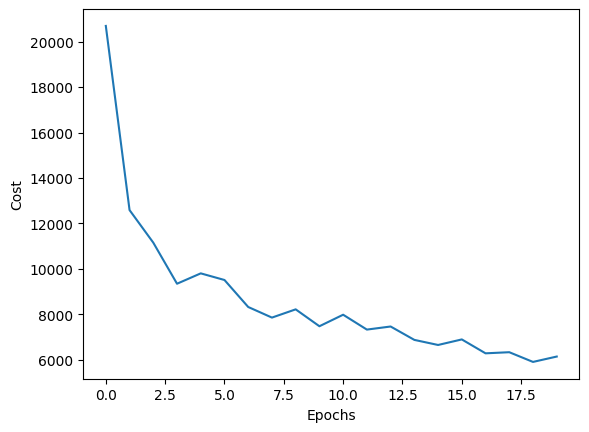

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(MLP.epochs), MLP.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

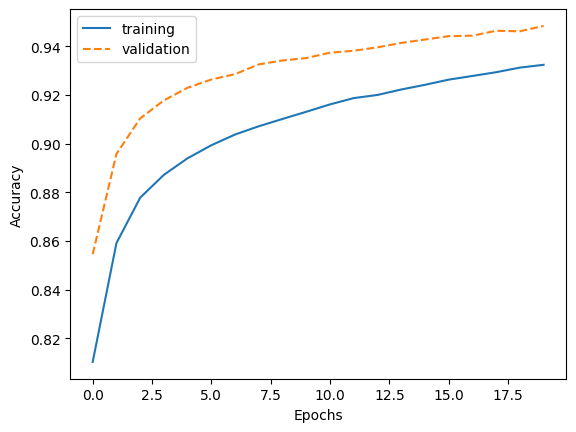

In [11]:
plt.plot(range(MLP.epochs), MLP.eval_['train_acc'], label='training')
plt.plot(range(MLP.epochs), MLP.eval_['valid_acc'], label='validation',linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [12]:
y_test_pred = MLP.predict(x_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / x_test.shape[0])
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 93.51%


C:\Users\acer\AppData\Local\Temp\ipykernel_652\3249258343.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = (np.sum(y_test == y_test_pred).astype(np.float) / x_test.shape[0])


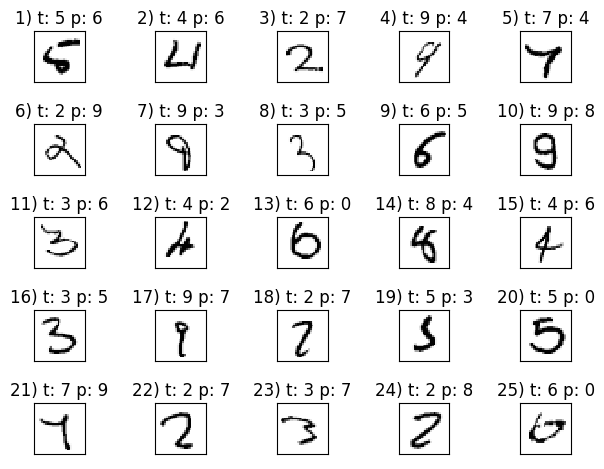

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
miscl_img = x_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('images/12_09.png', dpi=300)
plt.show()